In [1]:
import pandas as pd
import rdflib
from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.namespace import DC, FOAF
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.community as nx_comm
import networkx as nx
from owlready2 import *
from owlready2 import get_ontology
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.community as nx_comm

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [3]:
onto = get_ontology("http://example.org/medsur.owl")

class Patients(Thing):
    namespace = onto

class AgeGroup(Thing):
    namespace = onto
 
class hasAgeGroup(ObjectProperty):                  # TODO: do we need to define ranges for our properties?
    domain = [Patients]
    range = [AgeGroup]
    namespace = onto
  
class WeightGroup(Thing):
    namespace = onto
    
class hasWeightGroup(ObjectProperty):   # is this range correct if we connect patient directly to weightgroup is rdf tripple, else delete range
    domain = [Patients]
    range = [WeightGroup]
    namespace = onto
    
class Symptoms(Thing):
    namespace = onto
    
class hasSymptom(ObjectProperty):
    domain = [Patients]
    range = [Symptoms]
    namespace = onto

class Outcome(Thing):
    namespace = onto
    
class hasOutcome(ObjectProperty):
    domain = [Patients]
    range = [Outcome]
    namespace = onto
    
class Gender(Thing):
    namespace = onto

class hasGender(ObjectProperty):
    domain = [Patients]
    range = [Gender]
    namespace = onto

class Drug(Thing):
    namespace = onto
    
class IsGivenDrug(ObjectProperty):
    domain = [Patients]
    range = [Drug]
    namespace = onto
    
class IsOfDosis(ObjectProperty):
    domain = [Drug]
    namespace = onto
    
class IsOfType(ObjectProperty):
    domain = [Drug]
    namespace = onto

class SideEffects(Thing):
    namespace = onto
    
class hasSideEffect(ObjectProperty):
    domain = [Drug]
    range = [SideEffects]
    namespace = onto
    
class hasFrequency(ObjectProperty):                 
    domain = [SideEffects]
    namespace = onto 


In [4]:
onto.save(file = "medsur.rdf", format = "rdfxml") 
g = rdflib.Graph()
g.parse("medsur.rdf", format="xml")

# Loop through each triple in the graph (subj, pred, obj)
for subj, pred, obj in g:
    
    # Check if there is at least one triple in the Graph
    if (subj, pred, obj) not in g:
       raise Exception("It better be!")

# Print the number of "triples" in the Graph
print(f"Graph g has {len(g)} statements.")

Graph g has 44 statements.


In [5]:
data_patients = pd.read_excel('output_opioid.xlsx')
data_patients.head()

,Unnamed: 0,ID,WorldwideUniqueCaseIdentification,Status,Category,BodyWeight,Height,BMI,BMIGroup,date_received,...,HLTGName,SOCCode,SOCName,SOCAbbreviation,IsCurrent,IsDefaultSOC,Primary Source Description,summary,narrative,Dosage
0,0,1,CF-NL-09-249,40,NaN,NaN,NaN,NaN,NaN,2009-12-14,...,Psychiatric disorders NEC,10037175,Psychiatric disorders,Psych,1,1,she had become dependant of pain killers and s...,Automatic summary of the report by the Netherl...,The following information was published in the...,50MG
1,1,2,CF-NL-09-249,40,NaN,NaN,NaN,NaN,NaN,2009-12-14,...,Therapeutic and nontherapeutic effects (excl t...,10018065,General disorders and administration site cond...,Genrl,1,1,paracetamol and codeine no longer sufficiently...,Automatic summary of the report by the Netherl...,The following information was published in the...,50MG
2,2,3,ES-KYOWAKIRIN-2019BKK009955,40,NaN,NaN,NaN,NaN,NaN,2019-06-19,...,Parathyroid gland disorders,10014698,Endocrine disorders,Endo,1,0,Hypercalcemia,NaN,Case reference number 2019BKK009955 is a solic...,100UG/DO
3,3,4,ES-KYOWAKIRIN-2019BKK009955,40,NaN,NaN,NaN,NaN,NaN,2019-06-19,...,Deliria (incl confusion),10037175,Psychiatric disorders,Psych,1,1,Disorientation,NaN,Case reference number 2019BKK009955 is a solic...,100UG/DO
4,4,5,ES-KYOWAKIRIN-2019BKK009955,40,NaN,NaN,NaN,NaN,NaN,2019-06-19,...,"Bone, calcium, magnesium and phosphorus metabo...",10027433,Metabolism and nutrition disorders,Metab,1,1,Hypercalcemia,NaN,Case reference number 2019BKK009955 is a solic...,100UG/DO


In [6]:

data_sideeffects = pd.read_excel("sider_output.xlsx")
data_sideeffects.head()

,Unnamed: 0,STITCH code,ATCode,ATCText,PTConcept,Side effect,PTCode,Frequency
0,0,CID100002476,N02AE01,buprenorphine,C0000731,Abdominal distension,10000060,NaN
1,1,CID100002476,N02AE01,buprenorphine,C0687713,Gastrointestinal pain,10017999,NaN
2,2,CID100002476,N02AE01,buprenorphine,C0000737,Abdominal pain,10000081,NaN
3,3,CID100002476,N02AE01,buprenorphine,C0000833,Abscess,10000269,1.1%
4,4,CID100002476,N02AE01,buprenorphine,C0000833,Abscess,10000269,1.11%


In [8]:
def clean_data(data):
    # only select first row of data
    data = data[:100]
    
    # change all values in column "ID" to string
    data= data.astype(str)

    # replace all NaN, None, NaT, NULL, - values with empty string
    data = data.replace("NAN", '', regex=True)
    data = data.replace("nan", '', regex=True)
    data = data.replace("NaN", '', regex=True)
    data = data.replace("None", '', regex=True)
    data = data.replace('NaT', '', regex=True)
    data = data.replace('NULL', '', regex=True)
    data = data.replace('-', '', regex=True)
    
    return data


data_patients = clean_data(data_patients)
data_sideeffects = clean_data(data_sideeffects)
    
# replace all "" values in Age and BMI to "0"
data_patients["age_year"] = data_patients["age_year"].replace('', '0')
data_patients['BMI'] = data_patients['BMI'].replace('', '0')

In [12]:
# add RDF triples to the ontology
EX = rdflib.Namespace("http://example.org/medsur.rdf#")

for index, row in data_patients.iterrows():    
    
    patient = URIRef(EX, row['ID'])                     
    g.add((patient, RDF.type, EX.Patients))    
      
    if float(row["BMI"]) >= 30:                                 
        weightgroup = URIRef(EX, "Obese")                   # TODO: do we need to define the subclasses of weightgroup?
    elif float(row["BMI"]) >= 25:
        weightgroup = URIRef(EX, "Overweight")
    elif float(row["BMI"]) >= 18.5:
        weightgroup = URIRef(EX, "Normal")
    elif float(row["BMI"]) < 18.5:
        weightgroup = URIRef(EX, "Underweight")

    if weightgroup:                                   
        g.add((weightgroup, RDF.type, EX.WeightGroup))
        g.add((patient, EX.hasWeightGroup, weightgroup))
    
    if float(row["age_year"]) >= 65:
        agegroup = URIRef(EX, "65+")
    elif float(row["age_year"]) >= 45:
        agegroup = URIRef(EX, "45-64") 
    elif float(row["age_year"]) >= 25:
        agegroup = URIRef(EX, "25-44")
    elif float(row["age_year"]) >= 18:
        agegroup = URIRef(EX, "18-24")
    
    if agegroup:
        g.add((agegroup, RDF.type, EX.AgeGroup))
        g.add((patient, EX.hasAgeGroup, agegroup))
    
    if row["sex"] == "male" or row["sex"] == "female":
        gender = URIRef(EX, row["sex"])
        g.add((gender, RDF.type, EX.Gender))
        g.add((patient, EX.hasGender, gender))
            
    if row["Outcome"] != "Unknown" and row["Outcome"] != "":  
        outcome = URIRef(EX, row['Outcome'])
        g.add((outcome, RDF.type, EX.Outcome))
        g.add((patient, EX.hasOutcome, outcome))
      
    if row["PTCode"] != "":
        symptom = URIRef(EX, row['PTCode'])
        g.add((symptom, RDF.type, EX.Symptoms))
        g.add((patient, EX.hasSymptom, symptom))
      
    if row["ATCode"] != "":
        drug = URIRef(EX, row['ATCode'])              
        g.add((drug, RDF.type, EX.Drug))   
        g.add((patient, EX.isGivenDrug, drug))
  
        if row["Dosis"] != "":
            g.add((drug, EX.isOfDosis, Literal(row["Dosis"])))              # TODO: do we need to define a class for dosis and type?
        if row["Type"] != "":
            g.add((drug, EX.isOfType, Literal(row["Type"])))                                              

        df_sideeffects = data_sideeffects.loc[data_sideeffects['ATCode'] == row["ATCode"]]
  
        for index, row2 in df_sideeffects.iterrows():
            side_effect = URIRef(EX, row['ATCode'] + "_" + row2['PTCode'])
            g.add((side_effect, RDF.type, EX.SideEffects))
            g.add((drug, EX.hasSideEffect, side_effect))
            g.add((side_effect, EX.hasFrequency, Literal(row2['Frequency'])))         # TODO: do we need to define a class for frequency? 

Not recovered/not resolved/http:/example.org/medsur.rdf# does not look like a valid URI, trying to serialize this will break.
Not recovered/not resolved/http:/example.org/medsur.rdf# does not look like a valid URI, trying to serialize this will break.
Not recovered/not resolved/http:/example.org/medsur.rdf# does not look like a valid URI, trying to serialize this will break.
Not recovered/not resolved/http:/example.org/medsur.rdf# does not look like a valid URI, trying to serialize this will break.
Not recovered/not resolved/http:/example.org/medsur.rdf# does not look like a valid URI, trying to serialize this will break.


In [13]:
# print all the triples in the graph 
for s, p, o in g:
    print(s, p, o)

http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 10.8%
http://example.org/medsur.owl#Outcome http://www.w3.org/2000/01/rdf-schema#subClassOf http://www.w3.org/2002/07/owl#Thing
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 14.9%
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasOutcome Recovered/http:/example.org/medsur.rdf#
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 9.94%
http:/example.org/medsur.rdf# http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/medsur.rdf#AgeGroup
http://example.org/medsur.owl#hasOutcome http://www.w3.org/2000/01/rdf-schema#domain http://example.org/medsur.owl#Patients
Not recovered/not resolved/http:/example.org/medsur.rdf# http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/medsur.rdf#Outcome
http:/example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 1.11%
http://example.org/medsur.owl#IsOfType http://www.w3.org/2000/01/rd

In [19]:
nx_graph = rdflib_to_networkx_digraph(g)
print("Number of Nodes: {n}".format(n=nx.number_of_nodes(nx_graph)))
print("Number of Edges: {n}".format(n=nx.number_of_edges(nx_graph)))
print("Density of Graph: {n}".format(n=nx.density(nx_graph)))
print("Clustering coefficient: {n}".format(n=nx.average_clustering(nx_graph)))
print("Degree centrality:", nx.degree_centrality(nx_graph))

Number of Nodes: 95
Number of Edges: 118
Density of Graph: 0.013213885778275475
Clustering coefficient: 0.014039323661265838
Degree centrality: {rdflib.term.URIRef('http:/example.org/medsur.rdf#'): 0.776595744680851, rdflib.term.Literal('10.8%'): 0.010638297872340425, rdflib.term.URIRef('http://example.org/medsur.owl#Outcome'): 0.031914893617021274, rdflib.term.URIRef('http://www.w3.org/2002/07/owl#Thing'): 0.0851063829787234, rdflib.term.Literal('14.9%'): 0.010638297872340425, rdflib.term.URIRef('Recovered/http:/example.org/medsur.rdf#'): 0.02127659574468085, rdflib.term.Literal('9.94%'): 0.010638297872340425, rdflib.term.URIRef('http://example.org/medsur.rdf#AgeGroup'): 0.010638297872340425, rdflib.term.URIRef('http://example.org/medsur.owl#hasOutcome'): 0.031914893617021274, rdflib.term.URIRef('http://example.org/medsur.owl#Patients'): 0.0851063829787234, rdflib.term.URIRef('Not recovered/not resolved/http:/example.org/medsur.rdf#'): 0.02127659574468085, rdflib.term.URIRef('http://e

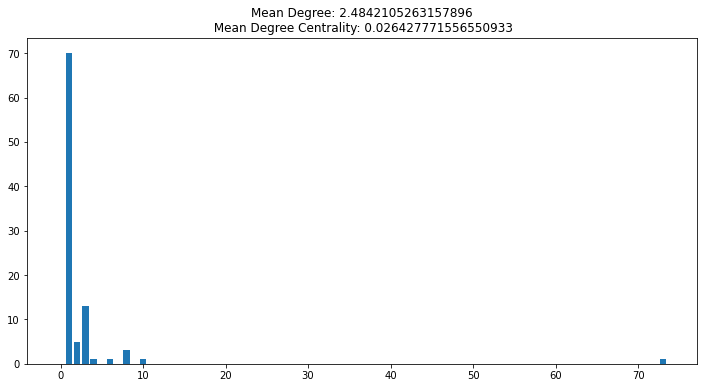

In [16]:
histdegree = pd.DataFrame(nx.degree_histogram(nx_graph))
degree = dict(nx.degree(nx_graph))

mean_degree = np.mean(list(degree.values()))
mean_degree_centrality = np.mean(list(nx.degree_centrality(nx_graph).values()))

fig, ax = plt.subplots(figsize=(12,6)) 
ax.bar(histdegree.index.values,histdegree[0])

plt.title("Mean Degree: {n1}\n Mean Degree Centrality: {n2}".format(n1=mean_degree,n2=mean_degree_centrality))
plt.show()

In [18]:
def find_blanknodes(g):
    blank_nodes = []
    BNode = rdflib.term.BNode
    for s, p, o in g:
        if isinstance(s, BNode):
            blank_nodes.append(s)
        if isinstance(o, BNode):
            blank_nodes.append(o)
    return blank_nodes 

print("Number of Blank Nodes: {n}".format(n=len(find_blanknodes(g))))

Number of Blank Nodes: 0


Number of found communitites 4 
 Number of nodes in the graph 85
0th community: 
 {'', '14.4%', 'SUBLINGUAAL', '16.1%', rdflib.term.Literal(''), '13.4%', '5.43%', '22.1%', '4.89%', 'TABLET', '14.1%', 'NEUSSPRAY', '6.11%', '6%', '11.4%', '12.1%', '6.54%', '13.8%', '13.3%', '3.23%', '2%', 'CAPSULE', '13%', '3.7%', '12%', '12.8%', '21.7%', '5%', '12.4%', '3%', '3.56%', '14.2%', '100UG/DO', '5.6%', '50MG', '1.11%', '20.4%', '10.3%', '9.94%', '11.2%', '7.77%', '1.1%', '7%', '2.72%', '15.1%', '2.8%', '1.61%', '2.21%', '11.7%', '9.78%', '2.19%', '10.8%', '15.6%', '4%', '4.85%', '14.9%', 'PLEISTER', '14%', '8.89%', '17.4%', '1%', '6.5%'}
1th community: 
 {'Outcome', 'hasOutcome', 'WeightGroup', 'Class', 'Thing', 'hasGender', 'AgeGroup', 'Patients', 'hasAgeGroup', 'Symptoms', 'hasWeightGroup', 'hasSymptom', 'Gender'}
2th community: 
 {'Drug', 'IsGivenDrug', 'SideEffects', 'hasFrequency', 'hasSideEffect', 'IsOfDosis', 'IsOfType', 'ObjectProperty'}
3th community: 
 {'http://example.org/medsur.owl

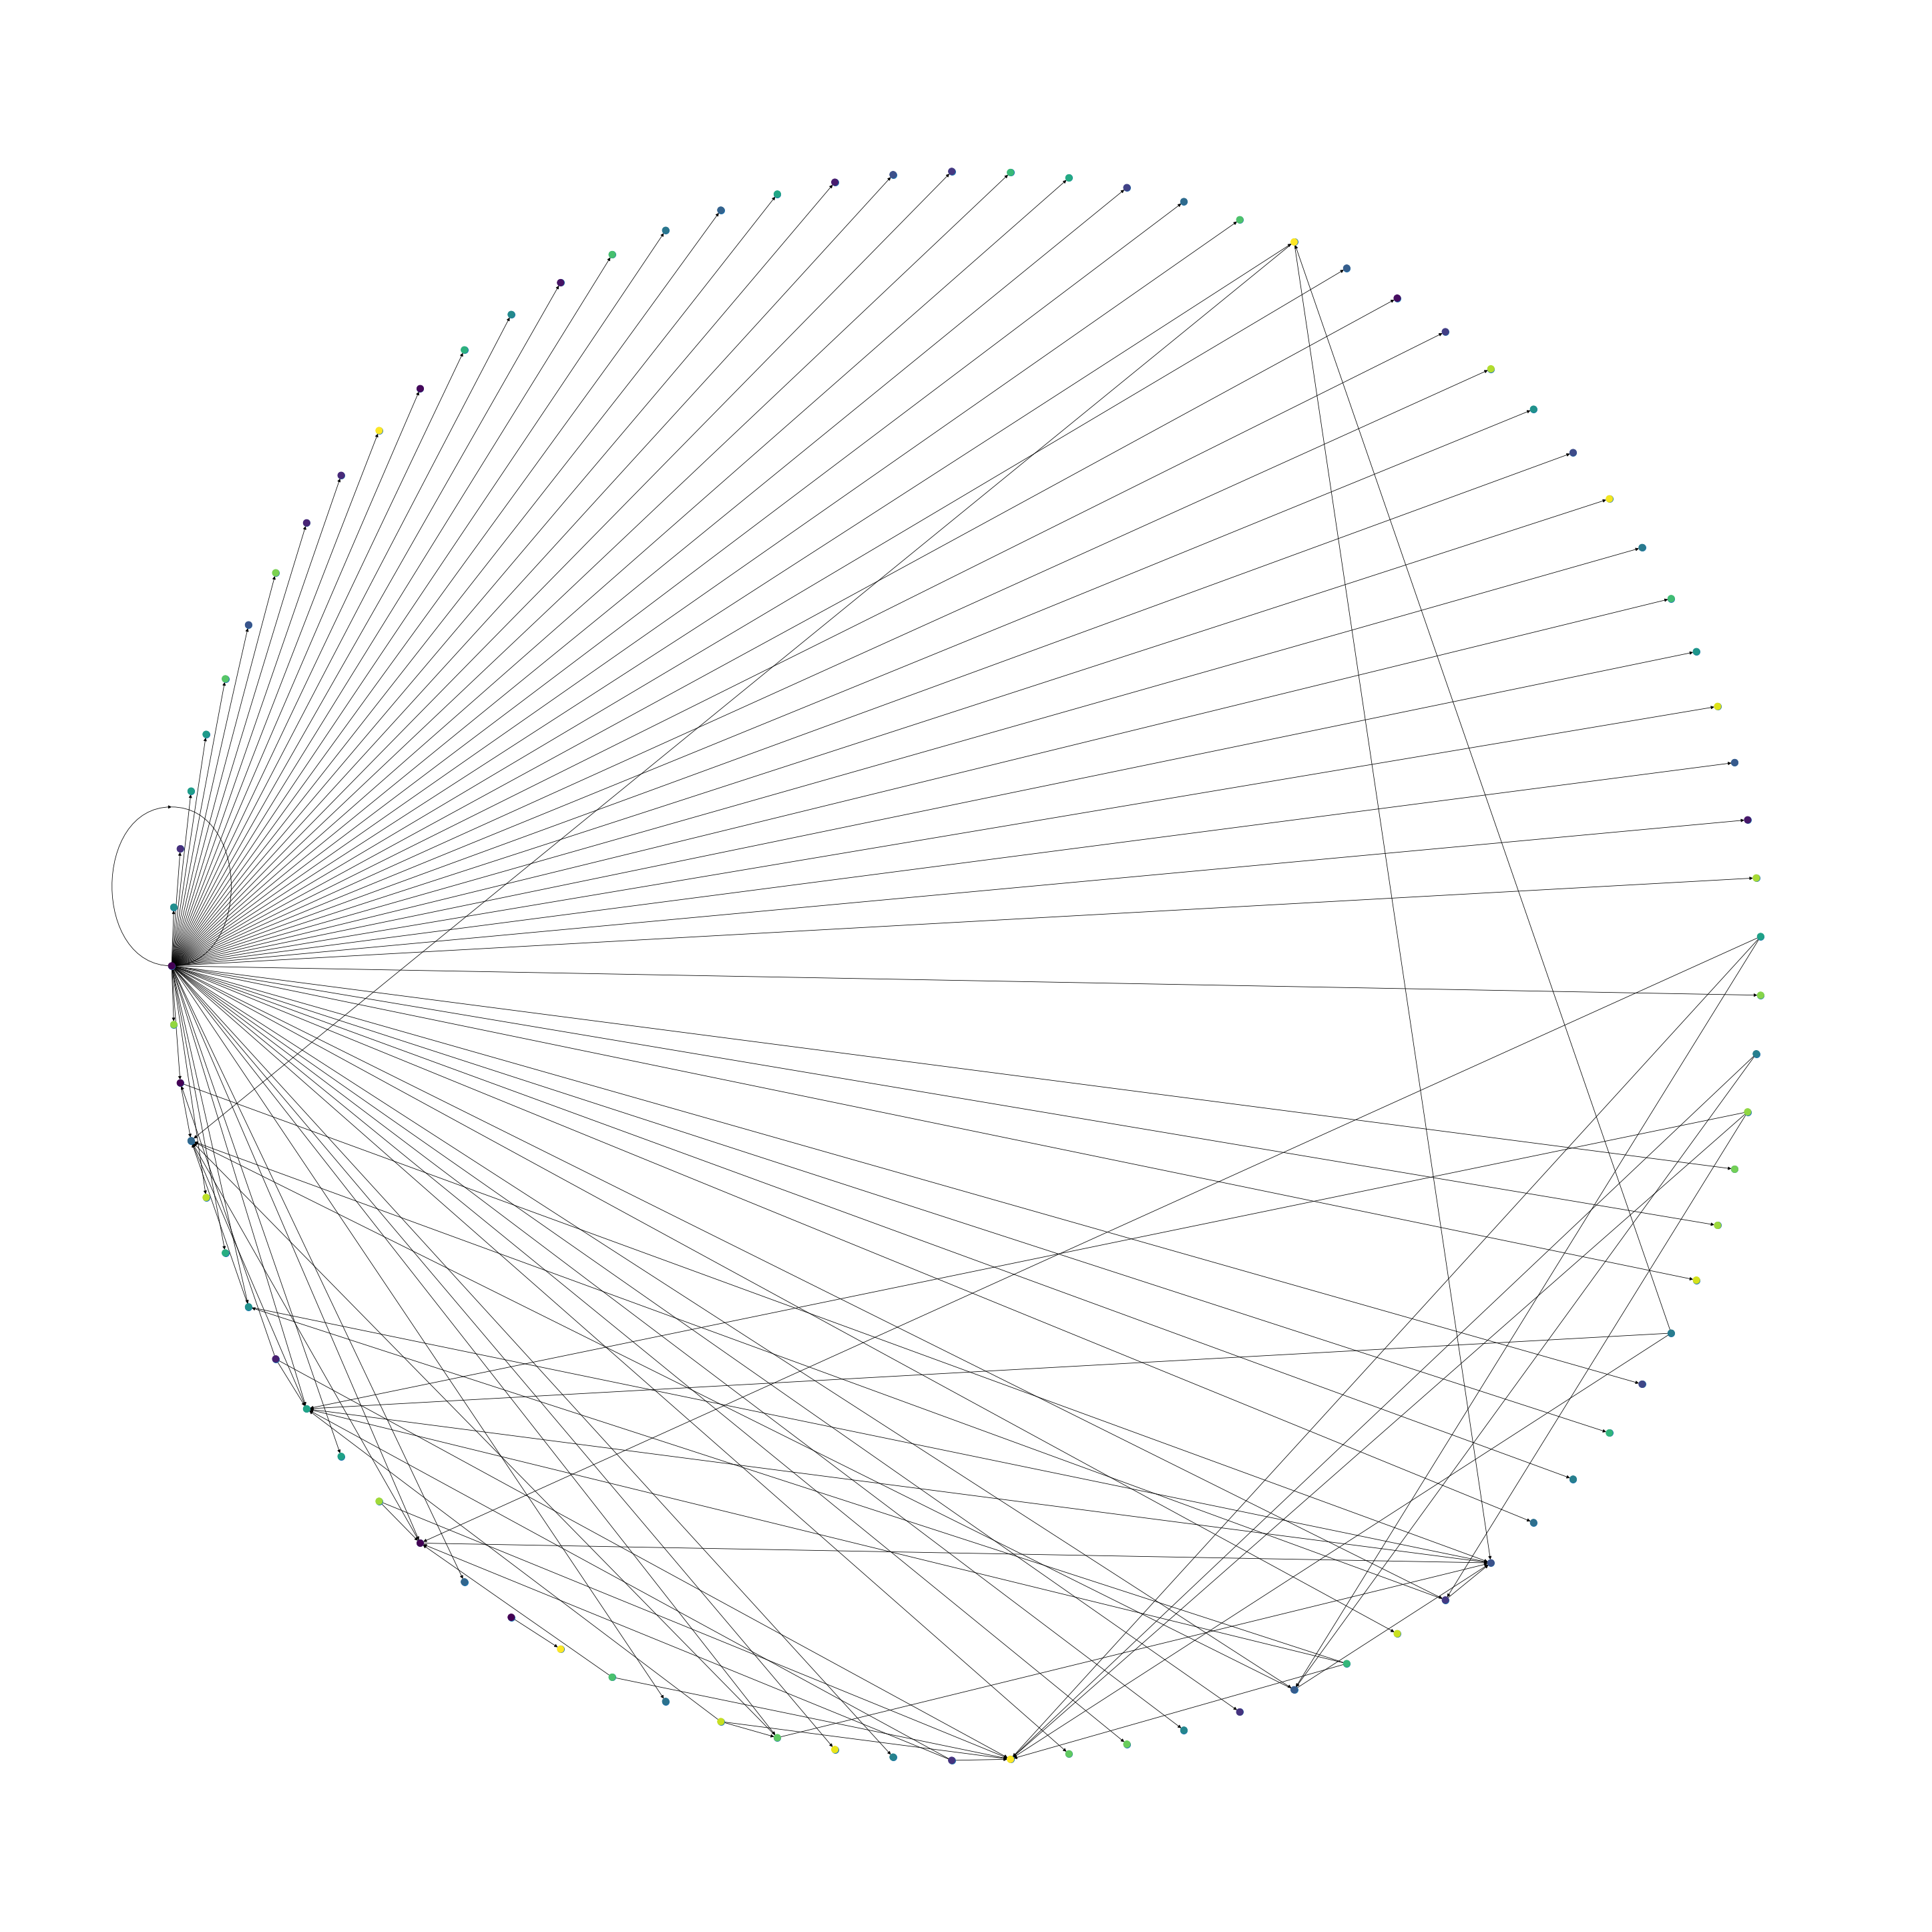

In [32]:
def clustering_louvain(nx_graph):
    
    mapping = pd.DataFrame(nx_graph.nodes())
    mapping['new_names'] = mapping[0].str.split("#",n=1,expand=False)
    mapping['label'] = 'NA'

    mapping_copy = mapping.copy()

    for ind, m in mapping_copy.iterrows():
        l = len(m['new_names'])
        names = m['new_names']
        mapping.loc[ind,'label'] = names[l-1]

    map_dict = dict(zip(mapping[0],mapping['label']))
    nx_graph_nl = nx.relabel_nodes(nx_graph, map_dict,copy=True)
    communities = nx_comm.louvain_communities(nx_graph_nl,resolution=1)
    print('Number of found communitites', len(communities),
    '\n Number of nodes in the graph',nx.number_of_nodes(nx_graph_nl))
    for i in range(len(communities)):
        print(f'{i}th community: \n',communities[i] )
        

    pos = nx.shell_layout(nx_graph_nl)
    nx.draw(nx_graph_nl, pos, edge_color='k',font_weight='light', 
            node_size= 100, width= 0.8)

    for com in communities:
        nx.draw_networkx_nodes(nx_graph_nl,
                            pos,
                            nodelist=com, 
                            #node_color=np.random.rand(3,),
                            node_color = range(len(com)),
                            label=True,
                            node_size=100)   
    return

clustering_louvain(nx_graph) 
    
    
